<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%
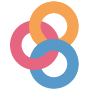

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/visualisation/maps.qmd")

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

{{% box status="note" title="Note" icon="fa fa-comment" %}}
Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 
{{% /box %}}




Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives


Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [2]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed


{{% box status="warning" title="Warning" icon="fa fa-exclamation-triangle" %}}
Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

{{% /box %}}

Installations préalables : 

~~~python
#| eval: false
#| echo: true
#| include: true

# Sur anaconda
conda install rtree --yes
~~~

~~~python
#| eval: false
#| echo: true
#| include: true

# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot
~~~


## Première carte avec l'API `matplotlib` de `geopandas`

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.


In [3]:
#| include: false

# 1. Chargement de "comptages"
comptages = pd.read_csv('https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv', compression = 'gzip')
#comptages.head()

2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


In [4]:
#| include: false

#2. Chargement de "compteurs"
compteurs = gpd.read_file("https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
#compteurs.head()

3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.


In [5]:
#| include: false

#3. Chargement de "arrondissements"
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
# arrondissements.head()

4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique

{{< /box >}}


<AxesSubplot:>

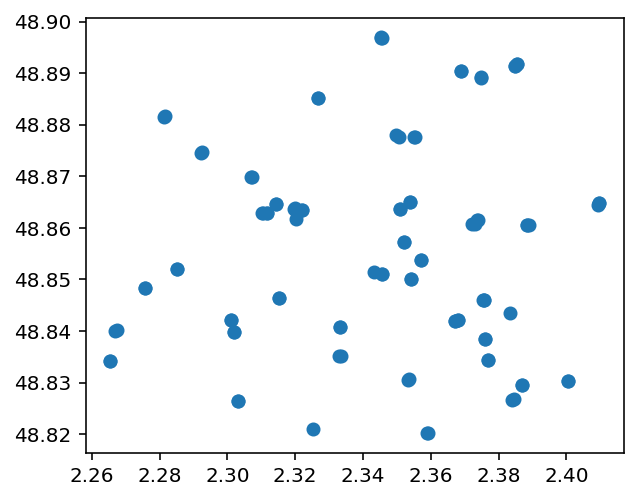

In [6]:
#| include: false

# 4. Localisation des compteurs
compteurs.plot()

{{% box status="warning" title="Warning" icon="fa fa-exclamation-triangle" %}}
On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  
{{% /box %}}




Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 


{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**


Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 


<AxesSubplot:>

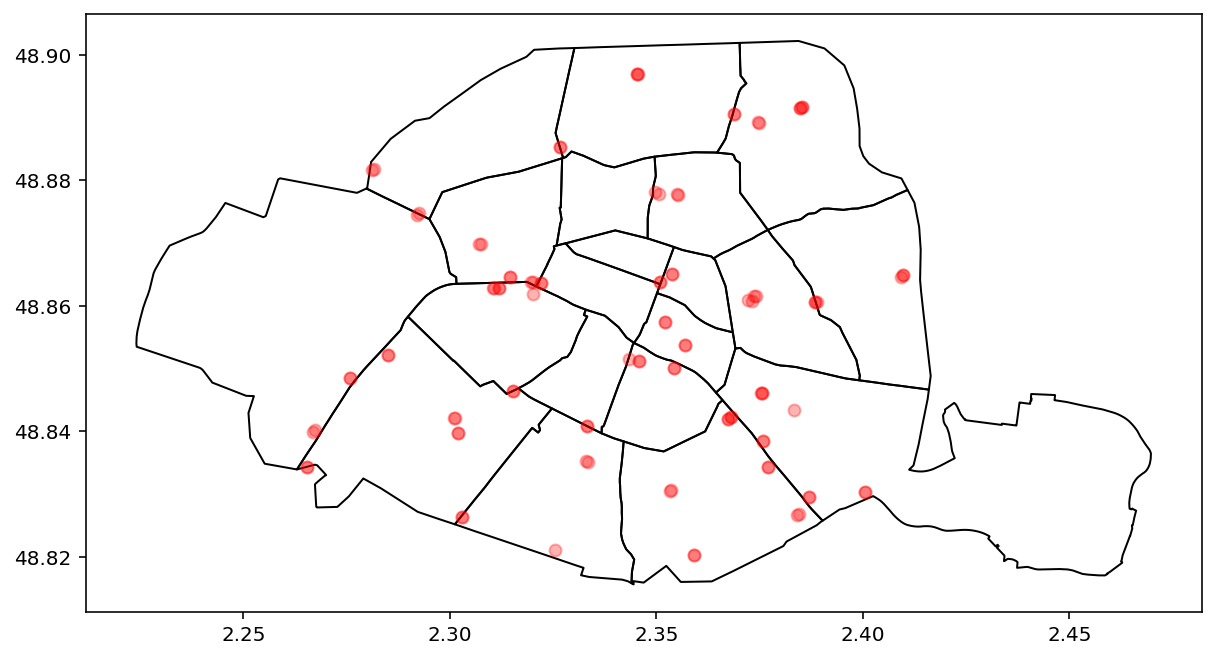

In [7]:
#| include: false
#| echo: false

# Carte des compteurs par arrondissement
ax = arrondissements.plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.plot(ax = ax, alpha = 0.3, color = 'red')
ax

Vous devriez obtenir cette carte:


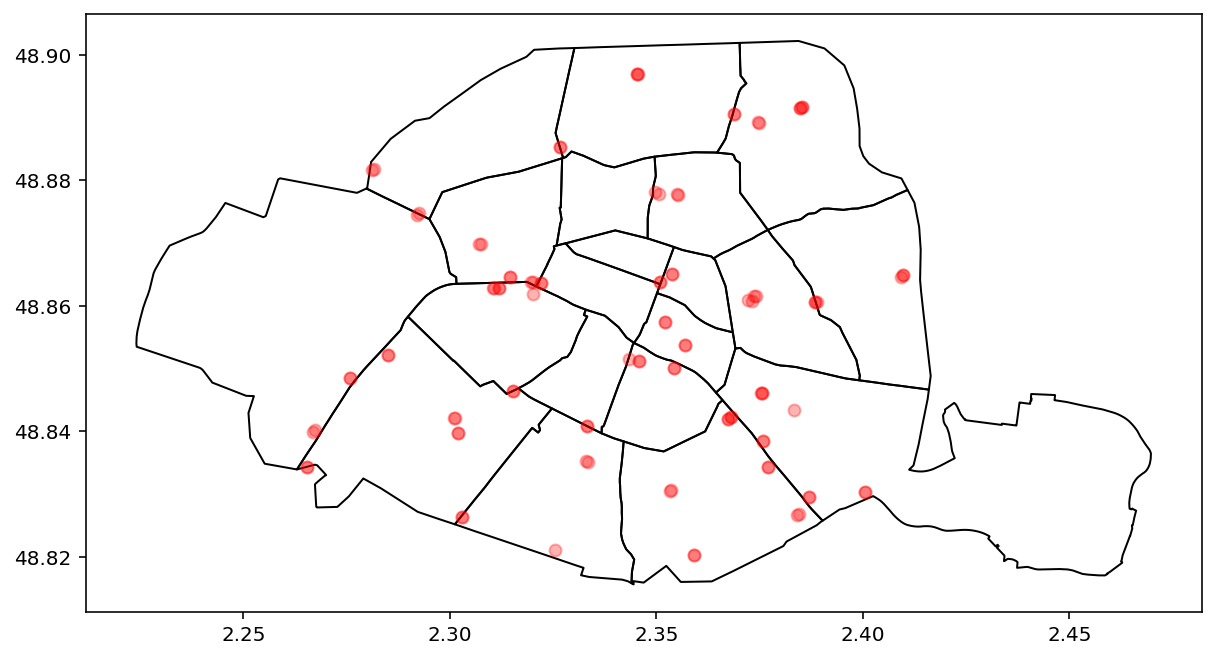

In [8]:
#| echo: false
ax.get_figure()

{{< /box >}}




{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}


**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*


<AxesSubplot:>

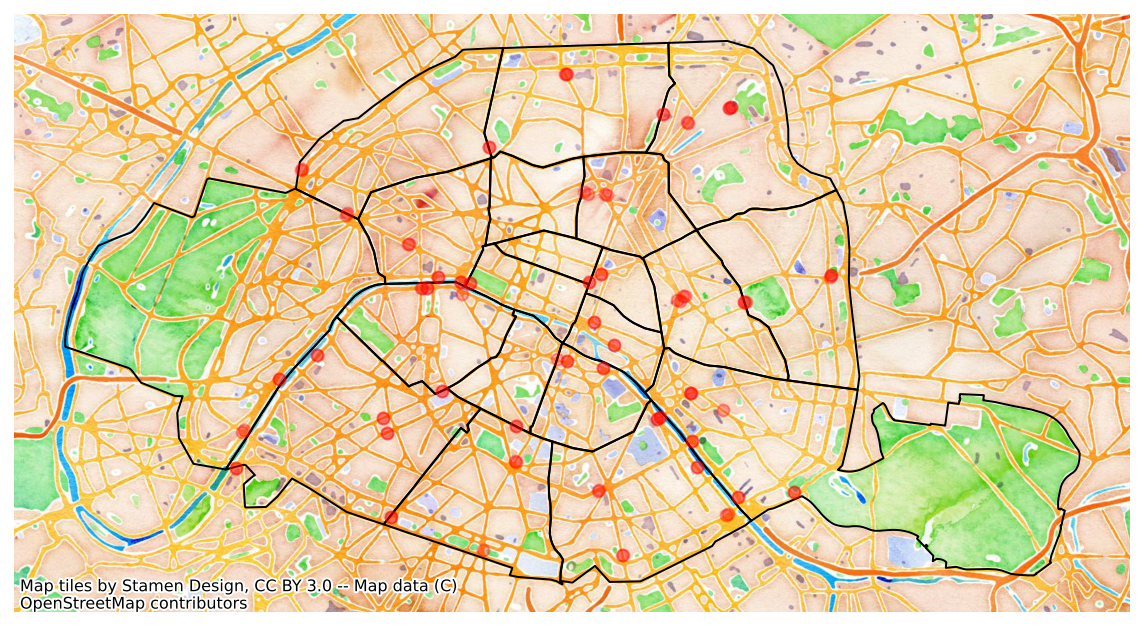

In [9]:
#| include: false
#| echo: false

# 1. Ajout d'un fond de carte sur la précédente carte
ax = arrondissements.to_crs("EPSG:3857").plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.to_crs("EPSG:3857").plot(ax = ax, alpha = 0.3, color = 'red')
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()
ax
#plt.savefig("map_arr2.png", bbox_inches='tight')

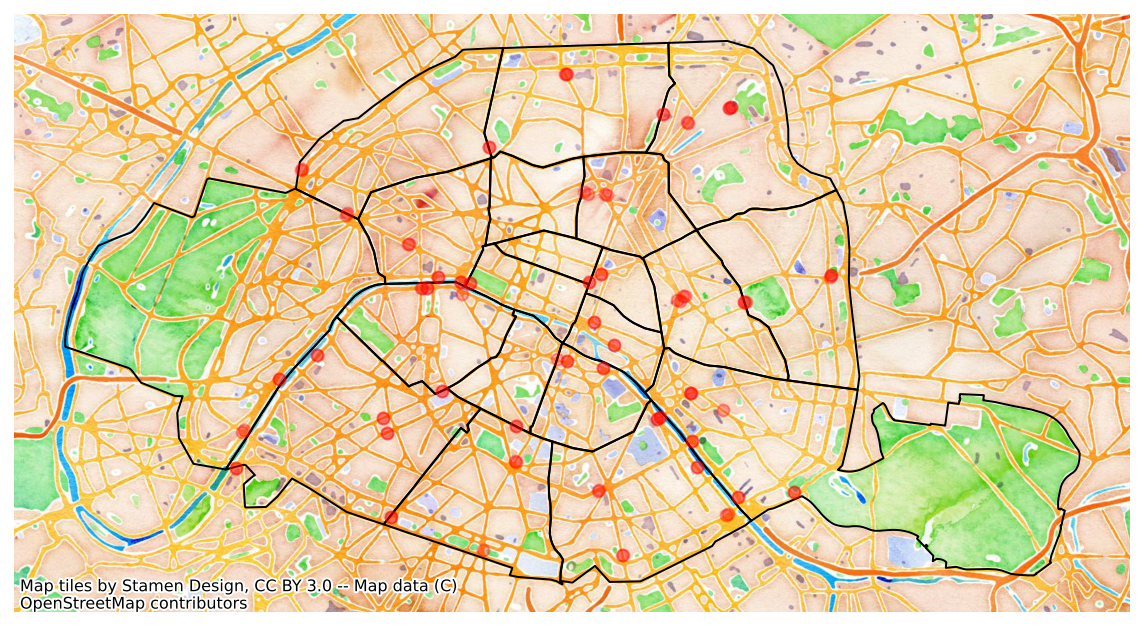

In [10]:
ax.get_figure()

2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 


<AxesSubplot:>

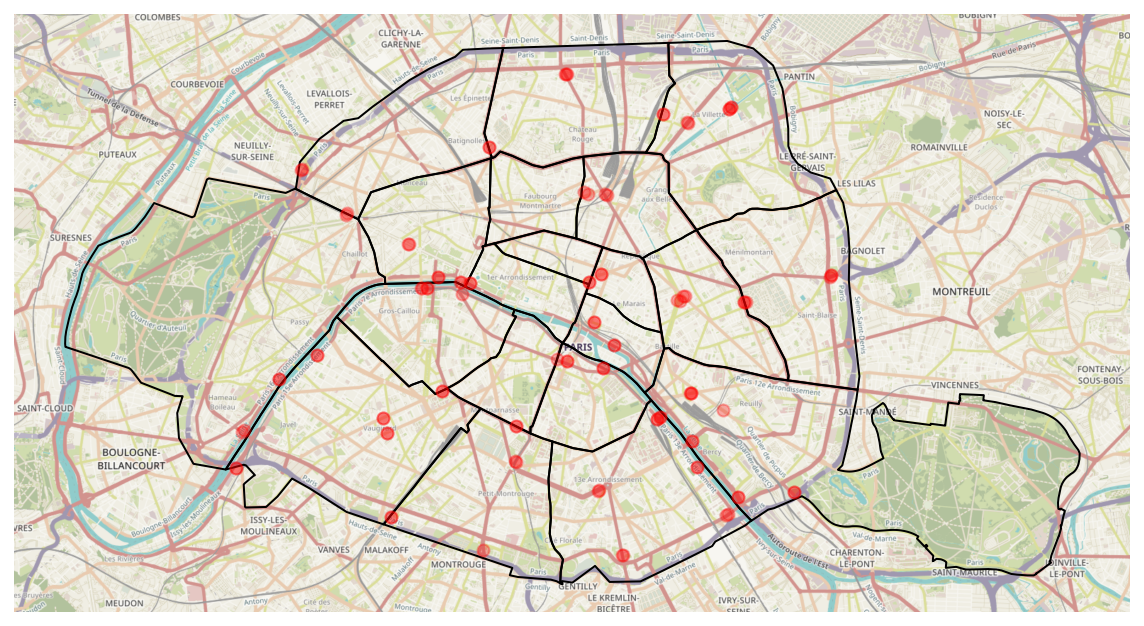

In [11]:
#| include: false
#| echo: false

# 2. Choix d'un fond de carte plus approprié (visualisation des grands axes)
ax = arrondissements.to_crs("EPSG:3857").plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.to_crs("EPSG:3857").plot(ax = ax, alpha = 0.3, color = 'red')
ctx.add_basemap(ax, source="https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png")
ax.set_axis_off()
ax

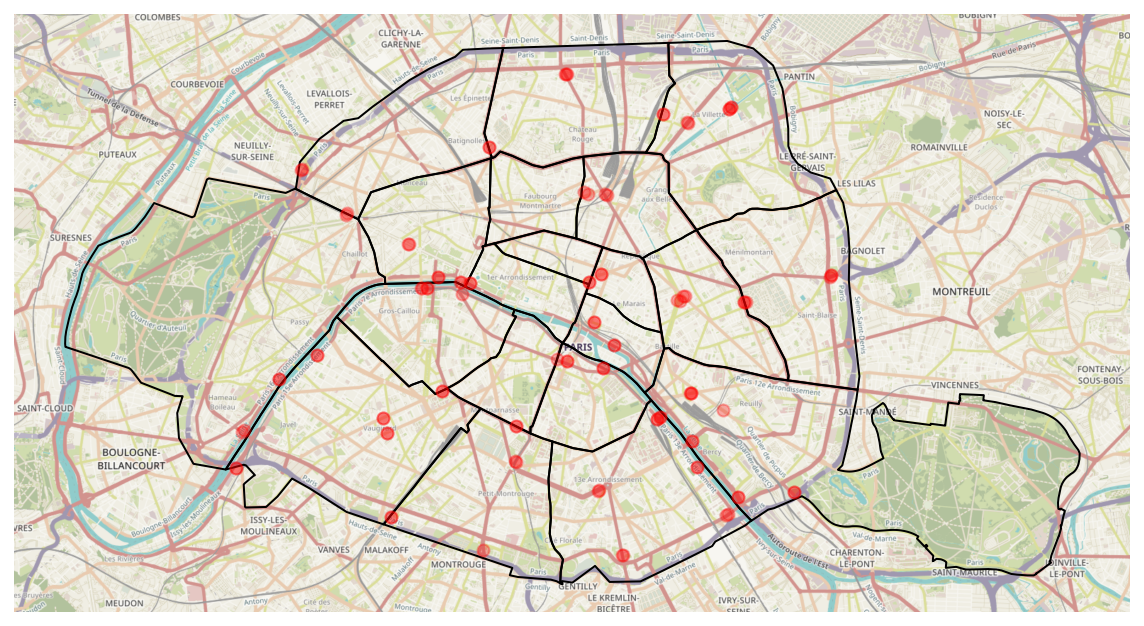

In [12]:
ax.get_figure()

{{< /box >}}



Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


{{% box status="note" title="Conseil" icon="fa fa-comment" %}}

Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [13]:
#| echo: true

import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% /box %}}


{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)


In [14]:
#| include: false
#| echo: false

#1. Calcul du trafic moyen
comptages['timestamp'] = pd.to_datetime(comptages['Date et heure de comptage'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
comptages['hour'] = comptages['timestamp'].dt.hour

df1 = comptages[comptages.hour.between(7,10)].groupby('Identifiant du compteur').agg({"Comptage horaire": "mean"}).reset_index()
df2 = comptages[comptages.hour.between(7,10)].groupby('Identifiant du compteur').agg({"Comptage horaire": "mean"}).reset_index()
df1 = compteurs.merge(df1, left_on = "id_compteur", right_on = 'Identifiant du compteur')
df2 = compteurs.merge(df2, left_on = "id_compteur", right_on = 'Identifiant du compteur')

2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)


In [15]:
#| include: false

#2. Creation de la fonction explode_data
## La fonction expand_points multiplie le nombre de points de manière à créer une heatmap
def explode_data(data, index_var = "id_compteur", weight_var = 'Comptage horaire', crs = 2154):
  data_exp = expand_points(data.to_crs(crs),
                  index_var = "id_compteur",
                  weight_var = 'Comptage horaire',
                  radius_sd = 100,
                  crs = crs)
  data_exp = data_exp.to_crs(4326)
  return data_exp

3. Appliquer cette fonction à `df1` et `df2`


In [16]:
#| include: false
#| echo: false

#3. Application de explode_data à df1 et df2
df1_exploded = explode_data(df1)
df2_exploded = explode_data(df2)

#print(len(df1))
#df1[["name","id_compteur"]].head()
#print(len(df1_exploded))
#df1_exploded[["name","npoints","x","y"]].head()

{{< /box >}}




{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 


/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.35 for `bw_method`, but please see the docs for the new parameters and update your code.

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning:

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.



<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

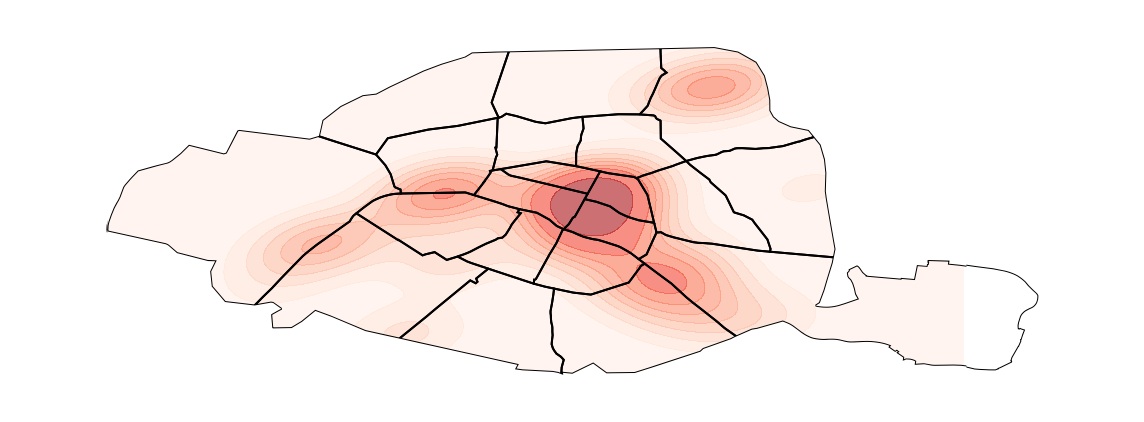

In [17]:
#| include: false
#| echo: false

# Exercice 5 : heatmap
fig = plt.figure()
ax = geoplot.kdeplot(df1_exploded,
                      figsize=(10, 10),
                      shade=True, shade_lowest=True,
                      alpha = 0.6,
                      clip = arrondissements,
                      cmap="Reds",
                      bw=.35
                    )
# truc bizarre: bandwidth doit etre beaucoup plus fort sur ma machine windows que sur un notebook tournant sur linux
# pour produire résultat équivalent
geoplot.polyplot(arrondissements, ax = ax, zorder = 1)

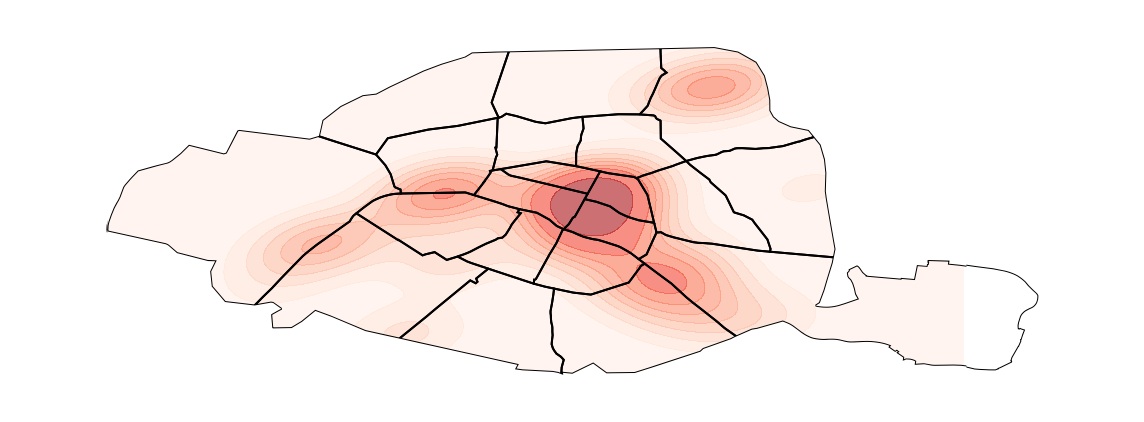

In [18]:
ax.get_figure()

{{< /box >}}




## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 


Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [19]:
#| echo: true
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

[48.85603805999998, 2.3436866]


Alors que le code suivant permet de calculer les coins:


In [20]:
#| echo: true
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw, ne)

[48.82024, 2.26542] [48.89696, 2.40966]


{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
Si un fond gris s'affiche, c'est qu'il y a un problème de localisation ou d'accès à internet. Pour le premier cas, cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`
{{% /box %}}


{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


In [21]:
#| include: false
#| echo: false

#1. Calcul du centre de la carte de "compteurs" et des bornes sw et ne
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()

2. Représenter la localisation des stations en utilisant un zoom optimal. 


In [22]:
#| include: false
#| echo: false

# 2. Carte interactive
from pathlib import Path
Path("leaflet").mkdir(parents=True, exist_ok=True)
m = folium.Map(location = center, tiles='Stamen Toner')

# Ajout des markers 1 à 1 sur la carte
for i in range(0,len(compteurs)):
    folium.Marker([compteurs.iloc[i]['lat'], compteurs.iloc[i]['lon']], popup=compteurs.iloc[i]['nom_compteur']).add_to(m)
m.fit_bounds([sw, ne])

In [23]:
m

{{% /box %}}


{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne


In [24]:
#| include: false
#| echo: false

# Exercice 7
df1['color'] = 'green'
top_10 = df1.sort_values('Comptage horaire', ascending = False).head(10).nom_compteur
df1.loc[df1.nom_compteur.isin(top_10.tolist()), 'color'] = 'red'

df1['lon'] = df1.geometry.x
df1['lat'] = df1.geometry.y
center = df1[['lat', 'lon']].mean().values.tolist()
sw = df1[['lat', 'lon']].min().values.tolist()
ne = df1[['lat', 'lon']].max().values.tolist()



m = folium.Map(location = center, tiles='Stamen Toner')

# I can add marker one by one on the map
for i in range(0,len(df1)):
   folium.Circle(
      location=[df1.iloc[i]['lat'], df1.iloc[i]['lon']],
      popup= df1.iloc[i]['nom_compteur'] + ": <br> " + str(df1.iloc[i]['Comptage horaire'].round()),
      radius=500*df1.iloc[i]['Comptage horaire']/df1.iloc[i]['Comptage horaire'].max(),
      color='grey',
      weight = 1,
      fill=True,
      fill_color=df1.iloc[i]['color'],
      fill_opacity=0.4
   ).add_to(m)

m.fit_bounds([sw, ne])

La carte obtenue doit ressembler à la suivante:


In [25]:
m

{{< /box >}}
